# 零基础实战机器学习

## 第15讲 会员流失情况判断

作者 黄佳

极客时间专栏链接：https://time.geekbang.org/column/intro/438


问题：判断易速鲜花会员的是否会流失情况

易速鲜花公司拥有多年的会员记录，以及会员停止续费的情况。

通过逻辑回归和神经网络等机器学习模型，我们可以判断出客户是否离开，这是一个典型的的二元分类问题。


## 数据的读入和预处理

In [1]:
import numpy as np # 导入NumPy
import pandas as pd # 导入Pandas
import matplotlib.pyplot as plt # 导入matplotlib.pyplot

In [2]:
df_member = pd.read_csv('易速鲜花会员留存.csv') # 导入数据包
df_member #显示数据

,用户码,性别,玫瑰套餐,紫罗兰套餐,郁金香套餐,百合套餐,康乃馨套餐,胡姬花套餐,生日套餐,情人节套餐,会员卡类型,入会月数,会费支付方式,平均月消费,总消费,已停付会费
0,1,女,是,是,否,是,否,是,是,否,年卡,9,手工转账,65.60,593.3,否
1,2,男,否,否,否,否,否,否,否,是,月卡,9,手工转账,59.90,542.4,否
2,3,男,否,否,否,否,是,否,否,否,月卡,4,就餐时付费,73.90,280.85,是
3,4,男,是,否,否,是,是,否,是,是,月卡,13,就餐时付费,98.00,1237.85,是
4,5,女,否,是,否,否,否,是,是,是,月卡,9,花呗付款,69.40,571.45,否
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,7039,女,否,否,是,否,否,是,否,否,年卡,13,手工转账,55.15,742.9,否
7039,7040,男,否,否,否,是,否,否,否,否,月卡,2,手工转账,50.30,92.75,否
7040,7041,男,是,否,否,否,否,否,否,是,月卡,22,就餐时付费,85.10,1873.7,是
7041,7042,男,是,是,是,否,是,是,否,是,双年卡,67,手工转账,67.85,4627.65,否


### 数据清洗

In [3]:
#把总消费字段转换成数值字段
df_member['总消费'] = pd.to_numeric(df_member['总消费'], errors='coerce')
df_member['总消费'].fillna(0, inplace=True)

### 数据可视化

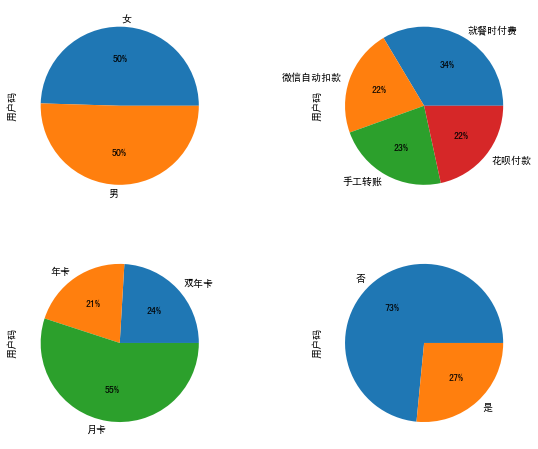

In [4]:
plt.figure(figsize=(10,8))
plt.subplot(2, 2, 1)
ax = df_member.groupby('性别').count()['用户码'].plot.pie(autopct='%1.0f%%') #饼图
plt.subplot(2, 2, 2)
ax = df_member.groupby('会费支付方式').count()['用户码'].plot.pie(autopct='%1.0f%%') #饼图
plt.subplot(2, 2, 3)
ax = df_member.groupby('会员卡类型').count()['用户码'].plot.pie(autopct='%1.0f%%') #饼图
plt.subplot(2, 2, 4)
ax = df_member.groupby('已停付会费').count()['用户码'].plot.pie(autopct='%1.0f%%') #饼图
plt.show() #显示

### 特征工程

In [5]:
df_member['已停付会费'].replace(to_replace='是', value=1, inplace=True) #流失-1
df_member['已停付会费'].replace(to_replace='否',  value=0, inplace=True) #未流失-0

In [6]:
df_member['性别'].replace(to_replace='女', value=0, inplace=True) #女生-0
df_member['性别'].replace(to_replace='男', value=1, inplace=True) #男生-1

In [7]:
# 字段中'Yes' or 'No'转换成为模型可以读取的数值,（布尔型数据，也是数值数据）
binary_features = ['玫瑰套餐', '紫罗兰套餐', '郁金香套餐', '百合套餐', '康乃馨套餐', '胡姬花套餐', 
                   '生日套餐','情人节套餐']
for field in binary_features:
    df_member[field] = df_member[field] == '是'

In [8]:
df_member

,用户码,性别,玫瑰套餐,紫罗兰套餐,郁金香套餐,百合套餐,康乃馨套餐,胡姬花套餐,生日套餐,情人节套餐,会员卡类型,入会月数,会费支付方式,平均月消费,总消费,已停付会费
0,1,0,True,True,False,True,False,True,True,False,年卡,9,手工转账,65.60,593.30,0
1,2,1,False,False,False,False,False,False,False,True,月卡,9,手工转账,59.90,542.40,0
2,3,1,False,False,False,False,True,False,False,False,月卡,4,就餐时付费,73.90,280.85,1
3,4,1,True,False,False,True,True,False,True,True,月卡,13,就餐时付费,98.00,1237.85,1
4,5,0,False,True,False,False,False,True,True,True,月卡,9,花呗付款,69.40,571.45,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,7039,0,False,False,True,False,False,True,False,False,年卡,13,手工转账,55.15,742.90,0
7039,7040,1,False,False,False,True,False,False,False,False,月卡,2,手工转账,50.30,92.75,0
7040,7041,1,True,False,False,False,False,False,False,True,月卡,22,就餐时付费,85.10,1873.70,1
7041,7042,1,True,True,True,False,True,True,False,True,双年卡,67,手工转账,67.85,4627.65,0


### 数据整理
先做数据整理工作，把每个数据字段都转换为可以处理的字段

In [9]:
# 分类字段哑变量
category_features = ['会员卡类型', '会费支付方式']
df_member = pd.get_dummies(df_member, drop_first=True, columns=category_features)
df_member

,用户码,性别,玫瑰套餐,紫罗兰套餐,郁金香套餐,百合套餐,康乃馨套餐,胡姬花套餐,生日套餐,情人节套餐,入会月数,平均月消费,总消费,已停付会费,会员卡类型_年卡,会员卡类型_月卡,会费支付方式_微信自动扣款,会费支付方式_手工转账,会费支付方式_花呗付款
0,1,0,True,True,False,True,False,True,True,False,9,65.60,593.30,0,1,0,0,1,0
1,2,1,False,False,False,False,False,False,False,True,9,59.90,542.40,0,0,1,0,1,0
2,3,1,False,False,False,False,True,False,False,False,4,73.90,280.85,1,0,1,0,0,0
3,4,1,True,False,False,True,True,False,True,True,13,98.00,1237.85,1,0,1,0,0,0
4,5,0,False,True,False,False,False,True,True,True,9,69.40,571.45,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,7039,0,False,False,True,False,False,True,False,False,13,55.15,742.90,0,1,0,0,1,0
7039,7040,1,False,False,False,True,False,False,False,False,2,50.30,92.75,0,0,1,0,1,0
7040,7041,1,True,False,False,False,False,False,False,True,22,85.10,1873.70,1,0,1,0,0,0
7041,7042,1,True,True,True,False,True,True,False,True,67,67.85,4627.65,0,0,0,0,1,0


### 构建特征集和标签集

In [10]:
X = df_member.drop(['用户码','已停付会费'], axis = 1) # 构建特征集，用户码字段属于无用特征
y = df_member.已停付会费.values # 构建标签集

### 拆分数据集

In [11]:
from sklearn.model_selection import train_test_split #导入train_test_split模块
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.2) #拆分数据集

## 选择算法

这里我们比较逻辑回归和神经网络两种算法

### 逻辑回归模型

### 导入模型

In [12]:
from sklearn.linear_model import LogisticRegression #导入逻辑回归模型
lr = LogisticRegression() # lr,就代表是逻辑回归模型

### 训练机器

In [13]:
lr.fit(X_train,y_train) # fit,就相当于是梯度下降

LogisticRegression()

### 评估分数

In [14]:
print("SK-learn逻辑回归预测准确率{:.2f}%".format(lr.score(X_test,y_test)*100))

SK-learn逻辑回归预测准确率81.48%


### 预测结果

In [15]:
y_pred=lr.predict(X_test)
print("逻辑回归对测试集第一个用户的预测结果", y_pred[0])

逻辑回归对测试集第一个用户的预测结果 0


### 神经网络模型

In [16]:
#!pip install keras
#!pip install tensorflow

In [17]:
import keras # 导入Keras库
from keras.models import Sequential # 导入Keras序贯模型
from keras.layers import Dense # 导入Keras密集连接层
dnn = Sequential() # 创建一个序贯DNN模型
dnn.add(Dense(units=12, input_dim=17, activation = 'relu')) # 添加输入层
dnn.add(Dense(units=24, activation = 'relu')) # 添加隐层
dnn.add(Dense(units=1, activation = 'sigmoid')) # 添加输出层
dnn.summary() # 显示网络模型（这个语句不是必须的）
# 编译神经网络，指定优化器，损失函数，以及评估标准
dnn.compile(optimizer = 'RMSProp', #优化器
            loss = 'binary_crossentropy', #损失函数
            metrics = ['acc']) #评估标准

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 12)                216       
_________________________________________________________________
dense_1 (Dense)              (None, 24)                312       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 25        
Total params: 553
Trainable params: 553
Non-trainable params: 0
_________________________________________________________________


In [19]:
X_train.shape #X_train目前的形状

(5634, 17)

In [20]:
X_train = np.asarray(X_train).astype(np.float32) # 转换为NumPy张量
X_test = np.asarray(X_test).astype(np.float32) # 转换为NumPy张量

In [21]:
X_train.dtype #X_train转换后的类型

dtype('float32')

In [22]:
history = dnn.fit(X_train, y_train, # 指定训练集
                  epochs=30,        # 指定训练的轮次
                  batch_size=64,    # 指定数据批量
                  validation_split=0.2) #这里直接从训练集数据中拆分验证集，更方便

Epoch 1/30
71/71 [==============================] - 1s 3ms/step - loss: 11.5413 - acc: 0.5727 - val_loss: 3.4338 - val_acc: 0.7560
Epoch 2/30
71/71 [==============================] - 0s 1ms/step - loss: 2.1439 - acc: 0.6408 - val_loss: 0.8800 - val_acc: 0.6717
Epoch 3/30
71/71 [==============================] - 0s 1ms/step - loss: 2.2731 - acc: 0.6554 - val_loss: 0.7427 - val_acc: 0.6681
Epoch 4/30
71/71 [==============================] - 0s 2ms/step - loss: 2.1159 - acc: 0.6676 - val_loss: 4.1969 - val_acc: 0.7613
Epoch 5/30
71/71 [==============================] - 0s 2ms/step - loss: 2.2573 - acc: 0.6798 - val_loss: 0.7482 - val_acc: 0.7161
Epoch 6/30
71/71 [==============================] - 0s 1ms/step - loss: 2.0974 - acc: 0.6858 - val_loss: 1.0754 - val_acc: 0.7613
Epoch 7/30
71/71 [==============================] - 0s 2ms/step - loss: 2.0184 - acc: 0.6916 - val_loss: 4.0026 - val_acc: 0.7684
Epoch 8/30
71/71 [==============================] - 0s 2ms/step - loss: 2.1611 - acc: 0.6

In [23]:
def show_history(history): # 显示训练过程中的学习曲线
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(loss) + 1)
    plt.figure(figsize=(12,4))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    plt.subplot(1, 2, 2)
    plt.plot(epochs, acc, 'bo', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show() 

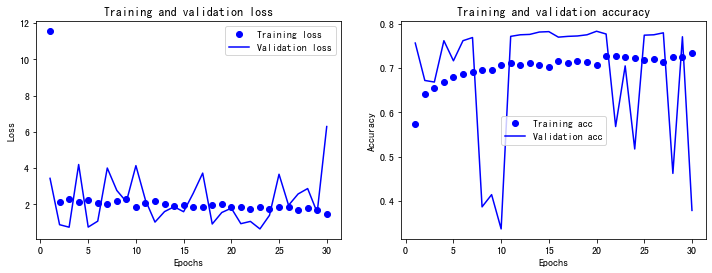

In [24]:
show_history(history) # 调用这个函数

In [25]:
result = dnn.evaluate(X_test, y_test) #评估测试集上的准确率
print('DNN的测试准确率为',"{0:.2f}%".format(result[1]*100))

45/45 [==============================] - 0s 997us/step - loss: 6.5827 - acc: 0.3811
DNN的测试准确率为 38.11%


In [26]:
prediction = dnn.predict(X_test) #预测测试集的图片分类
print('第一个用户分类结果为:', np.argmax(prediction[0]))

第一个用户分类结果为: 0


### 神经网络模型-归一化之后

In [27]:
# from sklearn.model_selection import train_test_split
# X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.2)

In [28]:
# X_train = np.asarray(X_train).astype(np.float32)
# X_test = np.asarray(X_test).astype(np.float32)

In [29]:
from sklearn.preprocessing import MinMaxScaler #导入归一化缩放器
scaler = MinMaxScaler() #创建归一化缩放器
X_train = scaler.fit_transform(X_train) #拟合并转换训练集数据
X_test = scaler.transform(X_test) #转换测试集数据

Epoch 1/30
71/71 [==============================] - 0s 2ms/step - loss: 0.5396 - acc: 0.7242 - val_loss: 0.4931 - val_acc: 0.7489
Epoch 2/30
71/71 [==============================] - 0s 2ms/step - loss: 0.4807 - acc: 0.7610 - val_loss: 0.4759 - val_acc: 0.7569
Epoch 3/30
71/71 [==============================] - 0s 2ms/step - loss: 0.4606 - acc: 0.7706 - val_loss: 0.4695 - val_acc: 0.7533
Epoch 4/30
71/71 [==============================] - 0s 1ms/step - loss: 0.4534 - acc: 0.7724 - val_loss: 0.4634 - val_acc: 0.7587
Epoch 5/30
71/71 [==============================] - 0s 1ms/step - loss: 0.4492 - acc: 0.7766 - val_loss: 0.4592 - val_acc: 0.7569
Epoch 6/30
71/71 [==============================] - 0s 1ms/step - loss: 0.4452 - acc: 0.7828 - val_loss: 0.4612 - val_acc: 0.7631
Epoch 7/30
71/71 [==============================] - 0s 1ms/step - loss: 0.4423 - acc: 0.7826 - val_loss: 0.4577 - val_acc: 0.7657
Epoch 8/30
71/71 [==============================] - 0s 1ms/step - loss: 0.4398 - acc: 0.78

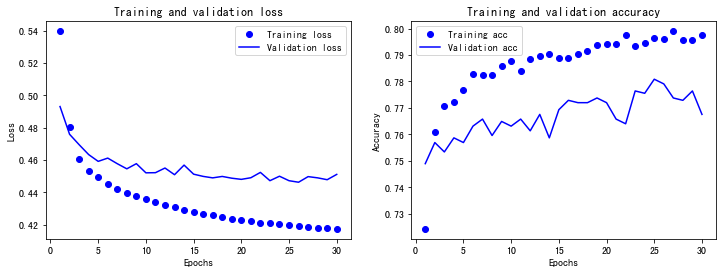

In [30]:
history = dnn.fit(X_train, y_train, # 指定训练集
                  epochs=30,        # 指定训练的轮次
                  batch_size=64,    # 指定数据批量
                  validation_split=0.2) #指定验证集,这里为了简化模型，直接用训练集数据
show_history(history) # 调用这个函数

In [31]:
result = dnn.evaluate(X_test, y_test) #评估测试集上的准确率
print('DNN（归一化之后）的测试准确率为',"{0:.2f}%".format(result[1]*100))

45/45 [==============================] - 0s 1ms/step - loss: 0.4146 - acc: 0.8105
DNN（归一化之后）的测试准确率为 81.05%
